In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
import seaborn as sns
import timedelta
import numpy as np

plt.rcParams['font.family'] = 'Malgun Gothic'  # or 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False


In [2]:
# 산림 데이터 불러오기 
frst_gdf = gpd.read_file("./modified_geopackage/merged100_converted(artif_included).gpkg")
frst_gdf.head()

,index,FIFTH_FRTP,DMCLS_CD,AGCLS_CD,DNST_CD,frtp_CD,geometry
0,0,H,2,4,B,활엽수림,"MULTIPOLYGON (((948832.506 1938334.243, 948821..."
1,1,H,2,4,B,활엽수림,"MULTIPOLYGON (((948400.28 1943550.352, 948436...."
2,2,H,2,4,B,활엽수림,"MULTIPOLYGON (((948917.086 1943877.663, 949068..."
3,3,H,2,5,B,활엽수림,"MULTIPOLYGON (((947921.377 1939678.505, 948085..."
4,4,H,2,5,B,활엽수림,"MULTIPOLYGON (((948903.335 1939687.335, 949128..."


In [3]:
# 읍면동 경계 불러오기 
emd = gpd.read_file(f"./emd/emd.shp", encoding="euc-kr")
emd.set_crs(epsg=5179, inplace=True)
emd = emd.to_crs(frst_gdf.crs)

<Axes: >

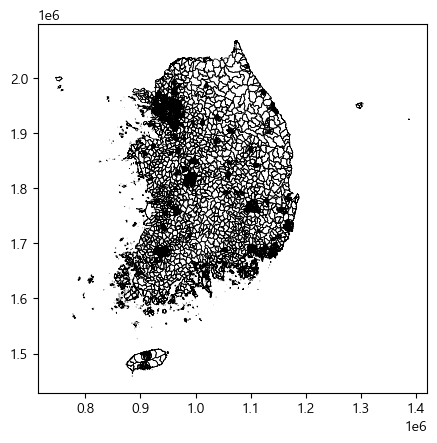

In [4]:
emd.boundary.plot(color = "black", linewidth = 0.5)

### Forest data를 split 후 각 읍면동으로 매핑 

In [4]:
# 각 데이터 준비 
frst = frst_gdf.to_crs(epsg=5179).copy()
frst.drop(columns = ["index"], inplace = True)

emd  = emd.to_crs(epsg=5179).copy()

In [5]:
frst

,FIFTH_FRTP,DMCLS_CD,AGCLS_CD,DNST_CD,frtp_CD,geometry
0,H,2,4,B,활엽수림,"MULTIPOLYGON (((948832.506 1938334.243, 948821..."
1,H,2,4,B,활엽수림,"MULTIPOLYGON (((948400.28 1943550.352, 948436...."
2,H,2,4,B,활엽수림,"MULTIPOLYGON (((948917.086 1943877.663, 949068..."
3,H,2,5,B,활엽수림,"MULTIPOLYGON (((947921.377 1939678.505, 948085..."
4,H,2,5,B,활엽수림,"MULTIPOLYGON (((948903.335 1939687.335, 949128..."
...,...,...,...,...,...,...
445510,Q,2,4,C,활엽수림,"MULTIPOLYGON (((1033189.479 1777946.008, 10334..."
445511,Q,2,5,B,활엽수림,"MULTIPOLYGON (((1032881.538 1777306.48, 103308..."
445512,Q,2,5,C,활엽수림,"MULTIPOLYGON (((1033589.258 1776815.165, 10334..."
445513,Q,2,5,C,활엽수림,"MULTIPOLYGON (((1033799.15 1777874.173, 103379..."


## 각 읍면동에 포함된 산림들 자르기

In [6]:
# 각 읍면동에 포함된 산림들 자르기
frst_split = gpd.overlay(
    frst,
    emd[['EMD_CD','geometry']],
    how='intersection'
)
frst_split

,FIFTH_FRTP,DMCLS_CD,AGCLS_CD,DNST_CD,frtp_CD,EMD_CD,geometry
0,H,2,4,B,활엽수림,11545103,"POLYGON ((948821.829 1938384.488, 948940.415 1..."
1,H,2,4,B,활엽수림,41171102,"POLYGON ((948879.366 1938398.549, 948893.738 1..."
2,H,2,4,B,활엽수림,11590109,"POLYGON ((948409.326 1943514.469, 948385.194 1..."
3,H,2,4,B,활엽수림,11620102,"POLYGON ((948436.09 1943408.298, 948553.999 19..."
4,H,2,4,B,활엽수림,11590109,"POLYGON ((949068.461 1943820.492, 949126.983 1..."
...,...,...,...,...,...,...,...
513081,Q,2,5,B,활엽수림,45730320,"POLYGON ((1033089.581 1777172.688, 1033111.162..."
513082,Q,2,5,C,활엽수림,45730310,"POLYGON ((1033476.936 1776591.666, 1033420.964..."
513083,Q,2,5,C,활엽수림,45730310,"POLYGON ((1033799.4 1777773.33, 1033783.626 17..."
513084,Q,2,5,C,활엽수림,45730320,"POLYGON ((1033799.296 1777815.447, 1033791.559..."


In [7]:
frst_split.drop(columns=["FIFTH_FRTP"], inplace = True)

## 순서형 변수를 각 구간 중간값으로 변환 

In [8]:
# 수목밀도 코드를 각 구간 중간값으로 변환 함수 
def convert_DNST(x):
    if x == "A":
        return 0.25
    elif x == "B":
        return 0.6
    elif x == "C":
        return 0.85
    else:
        return None
    
# 수림 종류를 침엽수림 비율로 변환 함수 
def convert_frtp_ratio(x):
    if x == "침엽수림":
        return 0.875
    elif x == "활엽수림":
        return 0.125
    elif x == "혼효림":
        return 0.5
    else:
        return None

# 경급 코드(나무 반지름cm)를 각 구간의 중간값으로 변환 함수 
def convert_DMCLS(x):
    if x == 0:
        return 3
    elif x == 1:
        return 11
    elif x == 2:
        return 23
    elif x == 3:
        return 35
    else:
        return None

In [9]:
# 수림 종류, 수목밀도, 경급 코드 변환 
frst_split["frtp_CD"] = frst_split["frtp_CD"].apply(convert_frtp_ratio)
frst_split["DNST_CD"] = frst_split["DNST_CD"].apply(convert_DNST)
frst_split["DMCLS_CD"] = frst_split["DMCLS_CD"].apply(convert_DMCLS)

In [10]:
frst_split

,DMCLS_CD,AGCLS_CD,DNST_CD,frtp_CD,EMD_CD,geometry
0,23,4,0.60,0.125,11545103,"POLYGON ((948821.829 1938384.488, 948940.415 1..."
1,23,4,0.60,0.125,41171102,"POLYGON ((948879.366 1938398.549, 948893.738 1..."
2,23,4,0.60,0.125,11590109,"POLYGON ((948409.326 1943514.469, 948385.194 1..."
3,23,4,0.60,0.125,11620102,"POLYGON ((948436.09 1943408.298, 948553.999 19..."
4,23,4,0.60,0.125,11590109,"POLYGON ((949068.461 1943820.492, 949126.983 1..."
...,...,...,...,...,...,...
513081,23,5,0.60,0.125,45730320,"POLYGON ((1033089.581 1777172.688, 1033111.162..."
513082,23,5,0.85,0.125,45730310,"POLYGON ((1033476.936 1776591.666, 1033420.964..."
513083,23,5,0.85,0.125,45730310,"POLYGON ((1033799.4 1777773.33, 1033783.626 17..."
513084,23,5,0.85,0.125,45730320,"POLYGON ((1033799.296 1777815.447, 1033791.559..."


## 각 읍면동 별로 산림들 최빈값 형식의 데이터(경급 DMCLS_CD, 영급 AGCLS_CD)의 가중 최빈값 구하기 

In [11]:
# 각 산림 별 (수목 밀도 x 넓이) 로 나무 개체 수 추정 => weights
frst_split["weights"] = frst_split.geometry.area * frst_split['DNST_CD']

In [12]:
# 가중치 주어질 때 최빈값 구하는 함수 
def weighted_mode(values: pd.Series, weights: pd.Series):
    df = pd.DataFrame({'val': values, 'w': weights})
    return df.groupby('val')['w'].sum().idxmax()

In [13]:
# 경급, 영급의 읍면동 별 가중 최빈값 계산 후 result df에 저장
cols = ['DMCLS_CD','AGCLS_CD']

result = (
    frst_split.groupby('EMD_CD')
    .apply(lambda df: pd.Series({
        col + '_wmode': weighted_mode(df[col], df['weights'])
        for col in cols}))
     .reset_index()
)

C:\Users\sc.lee\AppData\Local\Temp\ipykernel_19388\3709361130.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda df: pd.Series({


## 각 읍면동 별 침엽수림 비율 가중(수목 추정 개체수 = 수목밀도 x 넓이) 평균, 수목밀도 가중 평균

In [14]:
frtp_avg = frst_split.groupby('EMD_CD').apply(lambda df: pd.Series(
     {'frtp_avg': (df["frtp_CD"] * df['weights']).sum()/(df["weights"]).sum()})
     ).reset_index()

dnst_avg = frst_split.groupby('EMD_CD').apply(lambda df: pd.Series(
     {'dnst_avg': (df['weights']).sum()/(df["geometry"].area).sum()})
     ).reset_index()

C:\Users\sc.lee\AppData\Local\Temp\ipykernel_19388\2919383080.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  frtp_avg = frst_split.groupby('EMD_CD').apply(lambda df: pd.Series(
C:\Users\sc.lee\AppData\Local\Temp\ipykernel_19388\2919383080.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  dnst_avg = frst_split.groupby('EMD_CD').apply(lambda df: pd.Series(


In [15]:
# result에 저장 
result["frtp_avg"] = frtp_avg.frtp_avg
result["dnst_avg"] = dnst_avg.dnst_avg

## 각 읍면동 별 행정구역 전체 면적, 산림 전체 면적, 그 비율 구하기 

In [16]:
# 행정구역 전체 면적 
emd["Area"] = emd.geometry.area
result = result.merge(emd[["EMD_CD", "Area"]], how = "left", on = "EMD_CD")
result = result.merge(emd[["EMD_CD", "geometry"]], how = "left", on = "EMD_CD")

# result gdf로 변환
result = gpd.GeoDataFrame(result, geometry="geometry", crs = 5179)

In [17]:
# 행정구역 별 산림 데이터 union 후 면적 계산 
mtn = (frst_split.dissolve(by="EMD_CD").reset_index())[["EMD_CD", "geometry"]]
mtn["mtn_area"] = mtn.geometry.area
mtn

,EMD_CD,geometry,mtn_area
0,11110101,"MULTIPOLYGON (((953169.39 1954126.586, 953144....",6.752949e+04
1,11110102,"POLYGON ((952811.764 1954150.763, 952819.606 1...",5.986910e+04
2,11110103,"POLYGON ((953571.74 1954138.762, 953600.072 19...",7.769067e+02
3,11110109,"POLYGON ((952573.04 1953532.08, 952641.709 195...",7.901747e+04
4,11110111,"POLYGON ((952783.759 1954078.184, 952794.079 1...",1.134339e+05
...,...,...,...
3998,51830310,"MULTIPOLYGON (((1085734.796 1991232.665, 10857...",2.405751e+08
3999,51830320,"MULTIPOLYGON (((1099029.024 2001513.611, 10990...",2.536964e+07
4000,51830330,"MULTIPOLYGON (((1094435.003 1985643.915, 10944...",1.409661e+08
4001,51830340,"MULTIPOLYGON (((1104552.584 1989518.232, 11045...",4.654652e+07


In [18]:
# 산림 총 면적 읍면동마다 result에 저장 
result = result.merge(mtn[["EMD_CD", "mtn_area"]], how = "left", on = "EMD_CD")

In [19]:
# 총 산림 면적/총 면적 읍면동 별로 저장 
result["Mtn_Ratio"] = result.mtn_area/result.Area

In [20]:
result

,EMD_CD,DMCLS_CD_wmode,AGCLS_CD_wmode,frtp_avg,dnst_avg,Area,geometry,mtn_area,Mtn_Ratio
0,11110101,23,4,0.125000,0.600000,7.926179e+05,"POLYGON ((953700.022 1954605.065, 953693.871 1...",6.752949e+04,0.085198
1,11110102,23,4,0.125000,0.600000,9.882172e+04,"POLYGON ((953233.465 1953996.984, 953235.183 1...",5.986910e+04,0.605829
2,11110103,23,4,0.125000,0.600000,7.327165e+04,"POLYGON ((953560.228 1954257.466, 953561.19 19...",7.769067e+02,0.010603
3,11110109,23,4,0.125000,0.600000,2.585617e+05,"POLYGON ((952981.208 1953604.311, 952979.818 1...",7.901747e+04,0.305604
4,11110111,23,4,0.125000,0.600000,4.174383e+05,"POLYGON ((952769.058 1954155.954, 952765.16 19...",1.134339e+05,0.271738
...,...,...,...,...,...,...,...,...,...
3998,51830310,23,5,0.350721,0.838103,2.674577e+08,"POLYGON ((1079287.552 2011045.57, 1079356.15 2...",2.405751e+08,0.899488
3999,51830320,23,4,0.845896,0.829818,4.730166e+07,"MULTIPOLYGON (((1102997.769 2009910.288, 11029...",2.536964e+07,0.536337
4000,51830330,23,5,0.508427,0.828935,1.646645e+08,"MULTIPOLYGON (((1108475.024 2002913.557, 11084...",1.409661e+08,0.856081
4001,51830340,23,4,0.723005,0.791727,6.449621e+07,"MULTIPOLYGON (((1114466.017 1992227.421, 11145...",4.654652e+07,0.721694


### 묘지&농가, 도로&임도&등산로 데이터 이용해 인간 접근 가능한 산림 면적 구하기 

In [21]:
# 데이터 준비 
way = gpd.read_file("./modified_geopackage/Way_poly.gpkg")
place = gpd.read_file("./modified_geopackage/Place_poly.gpkg")

human_infl = gpd.GeoDataFrame(
    pd.concat([way, place], ignore_index=True),
    crs=way.crs
)

<Axes: >

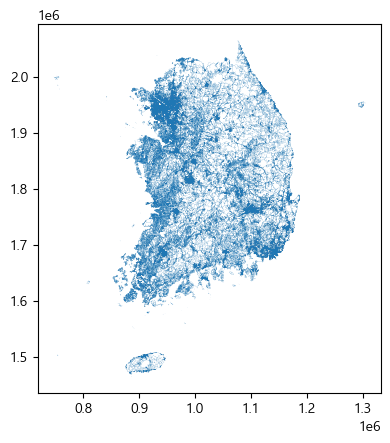

In [75]:
human_infl.plot()

In [22]:
# 읍면동 별 union된 산림과 인간접근가능 지역들의 겹치는 지역 추출 
human_infl_frst = gpd.overlay(mtn, human_infl, how = "intersection")
human_infl_frst.drop(columns=["mtn_area"], inplace=True)
human_infl_frst

,EMD_CD,geometry
0,11110101,"POLYGON ((953144.783 1954103.345, 953132.774 1..."
1,11110101,"POLYGON ((953144.783 1954103.345, 953132.774 1..."
2,11110101,"POLYGON ((953144.783 1954103.345, 953132.774 1..."
3,11110101,"POLYGON ((953021.73 1955032.946, 953038.995 19..."
4,11110101,"MULTIPOLYGON (((953150.437 1954108.685, 953149..."
...,...,...
286041,51830350,"MULTIPOLYGON (((1094362.108 2015696.23, 109413..."
286042,51830350,"MULTIPOLYGON (((1093961.939 2013957.129, 10939..."
286043,51830350,"MULTIPOLYGON (((1093100.297 2013842.545, 10930..."
286044,51830350,"POLYGON ((1097276.822 2012716.548, 1097298.195..."


In [23]:
# 읍면동 별로 인간접근가능 산림들 union, 면적 
human_infl_frst_U = (human_infl_frst.dissolve(by="EMD_CD").reset_index())
human_infl_frst_U["adj_area"] = human_infl_frst_U.geometry.area
human_infl_frst_U

,EMD_CD,geometry,adj_area
0,11110101,"MULTIPOLYGON (((953050.471 1954182.606, 953043...",3.611800e+04
1,11110102,"POLYGON ((953113.093 1953871.367, 953113.093 1...",4.049588e+04
2,11110109,"POLYGON ((952712.441 1953361.827, 952702.381 1...",7.707921e+04
3,11110111,"POLYGON ((952916.117 1953650.666, 952900.261 1...",1.134339e+05
4,11110113,"POLYGON ((952845.404 1953231.607, 952838.401 1...",3.724141e+03
...,...,...,...
3966,51830310,"MULTIPOLYGON (((1081054.542 2006209.654, 10810...",5.080019e+07
3967,51830320,"MULTIPOLYGON (((1099518.861 2000993.279, 10995...",4.406629e+06
3968,51830330,"MULTIPOLYGON (((1095043.914 1985323.89, 109494...",3.525345e+07
3969,51830340,"MULTIPOLYGON (((1106212.823 1989356.768, 11062...",1.370942e+07


In [24]:
# result에 읍면동 별 인간접근가능 산림 면적 저장 
result["human_adj_area"] = result["EMD_CD"].map(human_infl_frst_U.set_index("EMD_CD")["adj_area"]).fillna(0)

In [25]:
# result에 인간접근가능 산림 면적 / 산림 면적 저장
result["human_mtn_Ratio"] = result.human_adj_area/result.mtn_area

In [26]:
result

,EMD_CD,DMCLS_CD_wmode,AGCLS_CD_wmode,frtp_avg,dnst_avg,Area,geometry,mtn_area,Mtn_Ratio,human_adj_area,human_mtn_Ratio
0,11110101,23,4,0.125000,0.600000,7.926179e+05,"POLYGON ((953700.022 1954605.065, 953693.871 1...",6.752949e+04,0.085198,3.611800e+04,0.534848
1,11110102,23,4,0.125000,0.600000,9.882172e+04,"POLYGON ((953233.465 1953996.984, 953235.183 1...",5.986910e+04,0.605829,4.049588e+04,0.676407
2,11110103,23,4,0.125000,0.600000,7.327165e+04,"POLYGON ((953560.228 1954257.466, 953561.19 19...",7.769067e+02,0.010603,0.000000e+00,0.000000
3,11110109,23,4,0.125000,0.600000,2.585617e+05,"POLYGON ((952981.208 1953604.311, 952979.818 1...",7.901747e+04,0.305604,7.707921e+04,0.975470
4,11110111,23,4,0.125000,0.600000,4.174383e+05,"POLYGON ((952769.058 1954155.954, 952765.16 19...",1.134339e+05,0.271738,1.134339e+05,1.000000
...,...,...,...,...,...,...,...,...,...,...,...
3998,51830310,23,5,0.350721,0.838103,2.674577e+08,"POLYGON ((1079287.552 2011045.57, 1079356.15 2...",2.405751e+08,0.899488,5.080019e+07,0.211161
3999,51830320,23,4,0.845896,0.829818,4.730166e+07,"MULTIPOLYGON (((1102997.769 2009910.288, 11029...",2.536964e+07,0.536337,4.406629e+06,0.173697
4000,51830330,23,5,0.508427,0.828935,1.646645e+08,"MULTIPOLYGON (((1108475.024 2002913.557, 11084...",1.409661e+08,0.856081,3.525345e+07,0.250085
4001,51830340,23,4,0.723005,0.791727,6.449621e+07,"MULTIPOLYGON (((1114466.017 1992227.421, 11145...",4.654652e+07,0.721694,1.370942e+07,0.294532


<Axes: >

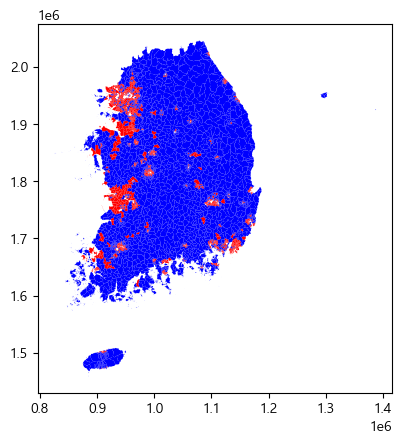

In [72]:
ax = emd[emd.EMD_CD.isin(result[result.human_mtn_Ratio>0.5].EMD_CD)].plot(color = "red")
emd[emd.EMD_CD.isin(result[result.human_mtn_Ratio<0.5].EMD_CD)].plot(ax = ax, color = "blue")

In [27]:
result["human_Total_Ratio"] = result.human_adj_area/result.Area

<Axes: >

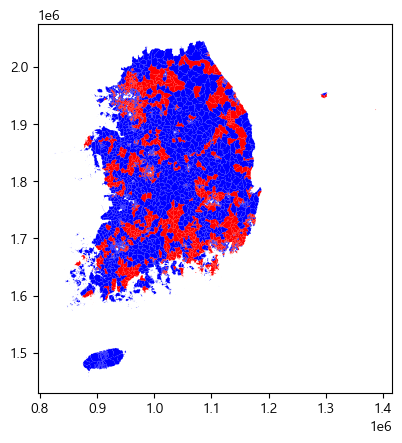

In [85]:
ax = emd[emd.EMD_CD.isin((result[result["human_Total_Ratio"]>0.15]).EMD_CD)].plot(color = "red")
emd[emd.EMD_CD.isin((result[result["human_Total_Ratio"]<0.15]).EMD_CD)].plot(ax = ax, color = "blue")

### 고도 데이터 추가 

In [111]:
alt = pd.read_csv("./elevation.csv")
alt

result.EMD_CD = result.EMD_CD.apply(int)
Result = result.merge(alt, on = "EMD_CD", how = "left")

In [112]:
Result

,EMD_CD,DMCLS_CD_wmode,AGCLS_CD_wmode,frtp_avg,dnst_avg,Area,geometry,mtn_area,Mtn_Ratio,human_adj_area,human_mtn_Ratio,human_Total_Ratio,Fire_Count,ctr_mean,ctr_std,n_ctrs
0,11110101,23,4,0.125000,0.600000,7.926179e+05,"POLYGON ((953700.022 1954605.065, 953693.871 1...",6.752949e+04,0.085198,3.611800e+04,0.534848,0.045568,0,173.809524,73.940935,21
1,11110102,23,4,0.125000,0.600000,9.882172e+04,"POLYGON ((953233.465 1953996.984, 953235.183 1...",5.986910e+04,0.605829,4.049588e+04,0.676407,0.409787,0,87.500000,32.274861,4
2,11110103,23,4,0.125000,0.600000,7.327165e+04,"POLYGON ((953560.228 1954257.466, 953561.19 19...",7.769067e+02,0.010603,0.000000e+00,0.000000,0.000000,0,50.000000,0.000000,1
3,11110109,23,4,0.125000,0.600000,2.585617e+05,"POLYGON ((952981.208 1953604.311, 952979.818 1...",7.901747e+04,0.305604,7.707921e+04,0.975470,0.298108,0,160.000000,71.879529,10
4,11110111,23,4,0.125000,0.600000,4.174383e+05,"POLYGON ((952769.058 1954155.954, 952765.16 19...",1.134339e+05,0.271738,1.134339e+05,1.000000,0.271738,0,187.500000,84.210131,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3998,51830310,23,5,0.350721,0.838103,2.674577e+08,"POLYGON ((1079287.552 2011045.57, 1079356.15 2...",2.405751e+08,0.899488,5.080019e+07,0.211161,0.189937,0,660.853909,344.959650,1458
3999,51830320,23,4,0.845896,0.829818,4.730166e+07,"MULTIPOLYGON (((1102997.769 2009910.288, 11029...",2.536964e+07,0.536337,4.406629e+06,0.173697,0.093160,0,97.925764,63.163660,229
4000,51830330,23,5,0.508427,0.828935,1.646645e+08,"MULTIPOLYGON (((1108475.024 2002913.557, 11084...",1.409661e+08,0.856081,3.525345e+07,0.250085,0.214093,0,369.624682,289.702053,786
4001,51830340,23,4,0.723005,0.791727,6.449621e+07,"MULTIPOLYGON (((1114466.017 1992227.421, 11145...",4.654652e+07,0.721694,1.370942e+07,0.294532,0.212562,0,199.795082,213.608011,366


### 산불 데이터에 발생한 읍면동 산불 발생 수 매핑  

In [113]:
# 산불 데이터 불러오기 
fire_gdf = gpd.read_file("./modified_geopackage/fire_clean.gpkg")
fire_gdf.head()

,발생장소_관서,발생장소_시도,발생장소_시군구,발생장소_읍면,발생장소_동리,발생원인_구분,발생원인_세부원인,발생원인_기타,피해면적_합계,발생장소_읍면동,...,EMD_CD,매핑수준,매핑방법,발생일시,진화일시,duration,index_right,지점명,distance,geometry
0,전북,전북,남원,산동,부절,기,작업장실화,산업현장실화,0.31,산동,...,45190410,완전 매칭,"시도,시군구,읍면동",2024-09-29 15:41:00,2024-09-30 16:30:00,24.816667,63,번암,0.075951,POINT (127.48083 35.50199)
1,경남,경남,밀양,None,내이,기,기타(직접입력),성묘객실화(벌집소각),0.10,내이,...,48270102,완전 매칭,"시도,시군구,읍면동",2024-09-10 15:55:00,2024-09-10 18:00:00,2.083333,522,생림,0.146043,POINT (128.74364 35.497)
2,충남,충남,부여,규암,수목,기,기타(직접입력),원인미상,0.03,규암,...,44760310,완전 매칭,"시도,시군구,읍면동",2024-09-10 14:35:00,2024-09-10 17:52:00,3.283333,296,정산,0.137384,POINT (126.86571 36.28309)
3,경북,경북,상주,화동,신촌,기,기타(직접입력),조사중,1.00,화동,...,47250400,완전 매칭,"시도,시군구,읍면동",2024-09-10 14:24:00,2024-09-10 22:00:00,7.600000,435,화서,0.051610,POINT (127.97244 36.398)
4,경북,경북,안동,녹전,매정,None,기타(직접입력),농산폐기물소각,0.05,녹전,...,47170430,완전 매칭,"시도,시군구,읍면동",2024-09-05 13:51:00,2024-09-05 16:10:00,2.316667,438,이산,0.145530,POINT (128.76731 36.75129)


In [114]:
# 읍면동마다 산불 횟수 매핑 
emd_counts = fire_gdf["EMD_CD"].value_counts()
Result.EMD_CD = Result.EMD_CD.apply(str)
Result["Fire_Count"] = Result["EMD_CD"].map(emd_counts).fillna(0).astype(int)

In [115]:
Result

,EMD_CD,DMCLS_CD_wmode,AGCLS_CD_wmode,frtp_avg,dnst_avg,Area,geometry,mtn_area,Mtn_Ratio,human_adj_area,human_mtn_Ratio,human_Total_Ratio,Fire_Count,ctr_mean,ctr_std,n_ctrs
0,11110101,23,4,0.125000,0.600000,7.926179e+05,"POLYGON ((953700.022 1954605.065, 953693.871 1...",6.752949e+04,0.085198,3.611800e+04,0.534848,0.045568,0,173.809524,73.940935,21
1,11110102,23,4,0.125000,0.600000,9.882172e+04,"POLYGON ((953233.465 1953996.984, 953235.183 1...",5.986910e+04,0.605829,4.049588e+04,0.676407,0.409787,0,87.500000,32.274861,4
2,11110103,23,4,0.125000,0.600000,7.327165e+04,"POLYGON ((953560.228 1954257.466, 953561.19 19...",7.769067e+02,0.010603,0.000000e+00,0.000000,0.000000,0,50.000000,0.000000,1
3,11110109,23,4,0.125000,0.600000,2.585617e+05,"POLYGON ((952981.208 1953604.311, 952979.818 1...",7.901747e+04,0.305604,7.707921e+04,0.975470,0.298108,0,160.000000,71.879529,10
4,11110111,23,4,0.125000,0.600000,4.174383e+05,"POLYGON ((952769.058 1954155.954, 952765.16 19...",1.134339e+05,0.271738,1.134339e+05,1.000000,0.271738,0,187.500000,84.210131,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3998,51830310,23,5,0.350721,0.838103,2.674577e+08,"POLYGON ((1079287.552 2011045.57, 1079356.15 2...",2.405751e+08,0.899488,5.080019e+07,0.211161,0.189937,1,660.853909,344.959650,1458
3999,51830320,23,4,0.845896,0.829818,4.730166e+07,"MULTIPOLYGON (((1102997.769 2009910.288, 11029...",2.536964e+07,0.536337,4.406629e+06,0.173697,0.093160,0,97.925764,63.163660,229
4000,51830330,23,5,0.508427,0.828935,1.646645e+08,"MULTIPOLYGON (((1108475.024 2002913.557, 11084...",1.409661e+08,0.856081,3.525345e+07,0.250085,0.214093,2,369.624682,289.702053,786
4001,51830340,23,4,0.723005,0.791727,6.449621e+07,"MULTIPOLYGON (((1114466.017 1992227.421, 11145...",4.654652e+07,0.721694,1.370942e+07,0.294532,0.212562,3,199.795082,213.608011,366


## Result 표 저장

In [117]:
Result.to_csv('Result_data.csv', index=False)

# Result data로 산불 횟수 plot

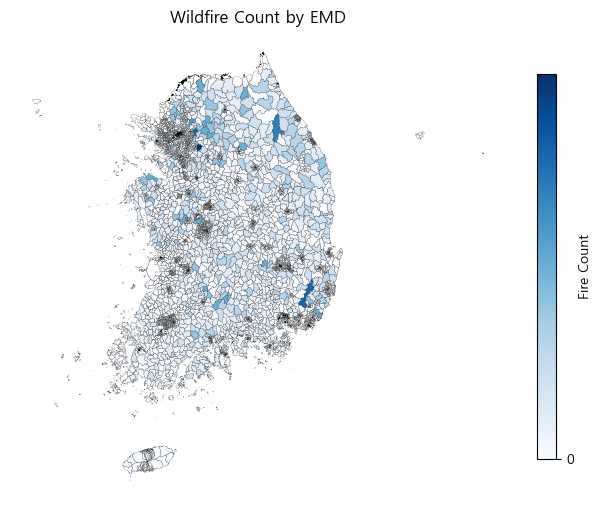

In [116]:
# 1) Set up figure
fig, ax = plt.subplots(figsize=(8, 10))

# 2) Plot with a single‐hue colormap and ask for a legend (colorbar)
Result.plot(
    column="Fire_Count",
    cmap="Blues",          # or "OrRd", "Greens", etc.
    linewidth=0.1,
    ax=ax,
    legend=True,
    legend_kwds={
        "shrink": 0.5,     # make colorbar smaller
        "label": "Fire Count"
    }
)
emd.boundary.plot(ax = ax, color = "black", linewidth = 0.1)

# 3) Tweak the colorbar to show integer ticks
cbar = ax.get_figure().axes[-1]  # the colorbar is the last axis
minc = int(result["Fire_Count"].min())
maxc = int(result["Fire_Count"].max())
cbar.set_yticks(np.arange(minc, maxc+1))       # one tick per integer
cbar.set_yticklabels(np.arange(minc, maxc+1))   # label them as integers

ax.set_title("Wildfire Count by EMD")
ax.axis("off")  # turn off axes for a cleaner map
plt.show()